<a href="https://www.kaggle.com/code/fongwaiyong/uber-fare-prediction?scriptVersionId=205704757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [47]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import math
import scipy
import geopy.distance
from tqdm import tqdm
from PIL import Image
import urllib.request

import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.formula import api
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [48]:
df = pd.read_csv('/kaggle/input/uber-fares-dataset/uber.csv')

df.drop(['Unnamed: 0', 'key'], axis=1, inplace=True)
display(df.head())

target = 'fare_amount'
features = [i for i in df.columns if i not in [target]]

# print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))
print(f'\n\033[1mInference:\033[0m The dateset consists of {df.shape[1]} & {df.shape[0]} samples.')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5



Inference: The dateset consists of 7 & 200000 samples.


In [49]:
# check for empty elements

# Null Values Count
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])

nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0], 3)
print(nvc)

df.dropna(inplace=True)

df.isnull().sum()

                   Total Null Values  Percentage
fare_amount                        0         0.0
pickup_datetime                    0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
passenger_count                    0         0.0
dropoff_longitude                  1         0.0
dropoff_latitude                   1         0.0


fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [50]:
# Reframe the columns

df = df[
(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
(df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
(df.pickup_latitude<180) & (df.dropoff_latitude<180) &
(df.pickup_latitude>-180) & (df.dropoff_latitude>-180)
]

df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

df

df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

df['Distance'] = [round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]), (df.dropoff_latitude[i], df.dropoff_longitude[i])).m, 2) for i in df.index]

df.drop(['pickup_datetime', 'month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73


In [51]:
# Check the dtypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199994 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199994 non-null  float64
 1   pickup_longitude   199994 non-null  float64
 2   pickup_latitude    199994 non-null  float64
 3   dropoff_longitude  199994 non-null  float64
 4   dropoff_latitude   199994 non-null  float64
 5   passenger_count    199994 non-null  int64  
 6   year               199994 non-null  int32  
 7   weekday            199994 non-null  int32  
 8   Monthly_Quarter    199994 non-null  object 
 9   Hourly_Segments    199994 non-null  object 
 10  Distance           199994 non-null  float64
dtypes: float64(6), int32(2), int64(1), object(2)
memory usage: 20.8+ MB


In [52]:
# Check number of unique rows in each feature
df.nunique().sort_values()

Monthly_Quarter           4
Hourly_Segments           6
year                      7
weekday                   7
passenger_count           8
fare_amount            1244
pickup_longitude      71061
dropoff_longitude     76892
pickup_latitude       83831
dropoff_latitude      90582
Distance             164549
dtype: int64

In [53]:
# Check number of unique rows in each feature
nu = df.drop([target], axis=1).nunique().sort_values()
# Numerical and categorical features
nf=[]; cf=[]; nnf=0; ncf=0

for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i]<=24:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print(f'\n\033[1mInference:\033[0m The dataset has {len(nf)} numerical & {len(cf)} categorical features.')


Inference: The dataset has 5 numerical & 5 categorical features.


In [54]:
# Check the stats of all the columns
display(df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Distance
count,199994.000000,199994.000000,199994.000000,199994.000000,199994.000000,199994.000000,199994.000000,199994.000000,1.999940e+05
mean,11.359865,-72.521918,39.917966,-72.514979,39.922060,1.684546,2011.742437,3.048416,2.071228e+04
std,9.901867,11.077069,6.130306,10.517790,6.117564,1.385999,1.856421,1.946950,3.805294e+05
min,-52.000000,-768.550000,-74.015515,-737.916665,-74.015750,0.000000,2009.000000,0.000000,0.000000e+00
25%,6.000000,-73.992065,40.734795,-73.991407,40.733823,1.000000,2010.000000,1.000000,1.215562e+03
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2012.000000,3.000000,2.121375e+03
75%,12.500000,-73.967155,40.767157,-73.963658,40.768000,2.000000,2013.000000,5.000000,3.874610e+03
max,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,2015.000000,6.000000,8.783594e+06


**Inference:** From the statistic shown above, it seems to be fine. There might be outlier, such as the maximum of fare_amount is 499 but the 75% of it is only 12.5.

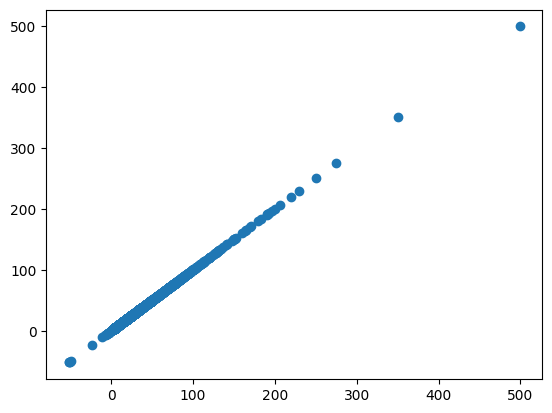

In [55]:
plt.scatter(df[target], df['fare_amount'])

---

# 2. Exploratory Data Analysis

In [56]:
'''import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request

# Open the image from the URL
url = 'https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/wm.png'
image = np.array(Image.open(urllib.request.urlopen(url)))
#image = np.array(Image.open(url))

plt.figure(figsize=[10,20])
plt.imshow(image, alpha=0.2)
plt.scatter((df.pickup_longitude + 180) * 3, (df.pickup_latitude + 215) * 1.45555555, alpha=0.3, color='red')
plt.show()
'''

"import numpy as np\nimport matplotlib.pyplot as plt\nfrom PIL import Image\nimport urllib.request\n\n# Open the image from the URL\nurl = 'https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/wm.png'\nimage = np.array(Image.open(urllib.request.urlopen(url)))\n#image = np.array(Image.open(url))\n\nplt.figure(figsize=[10,20])\nplt.imshow(image, alpha=0.2)\nplt.scatter((df.pickup_longitude + 180) * 3, (df.pickup_latitude + 215) * 1.45555555, alpha=0.3, color='red')\nplt.show()\n"

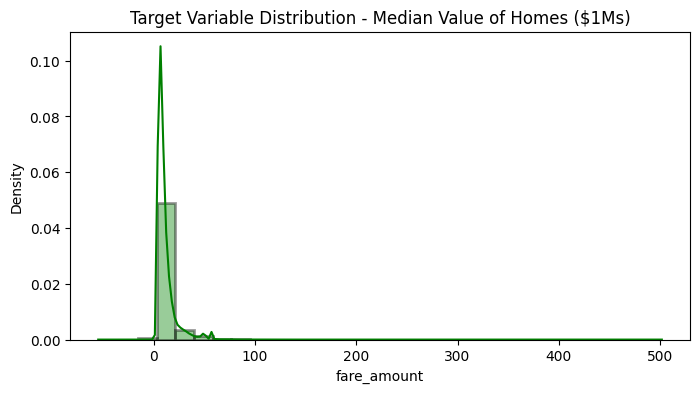

In [57]:
# Analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='green', hist_kws=dict(edgecolor='black', linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

**Inference:** It can be noticed that the target variable is highly skewed. The density of data points is highest near the zero, indicating that most fare amounts are relatively low. This could be due to a large number of short or low-cost trips.

To handle this skewed distribution, `log transformation` or other `normalization` techniques might need to be considered.

In [58]:
# This may help to improve the model

'''df['fare_amount_log'] = np.log1p(df['fare_amount'])  # log1p is log(1 + x) and helps handle zero values

plt.figure(figsize=[8,4])
sns.kdeplot(df['fare_amount_log'], shade=True)
plt.xlabel('Log of Fare Amount')
plt.ylabel('Density')
plt.show()'''


"df['fare_amount_log'] = np.log1p(df['fare_amount'])  # log1p is log(1 + x) and helps handle zero values\n\nplt.figure(figsize=[8,4])\nsns.kdeplot(df['fare_amount_log'], shade=True)\nplt.xlabel('Log of Fare Amount')\nplt.ylabel('Density')\nplt.show()"

In [59]:
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,6,Q4,H3,112.13
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,4,Q1,H1,1879.64
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,0,Q2,H1,12867.92
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,2,Q2,H4,3536.55


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199994 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199994 non-null  float64
 1   pickup_longitude   199994 non-null  float64
 2   pickup_latitude    199994 non-null  float64
 3   dropoff_longitude  199994 non-null  float64
 4   dropoff_latitude   199994 non-null  float64
 5   passenger_count    199994 non-null  int64  
 6   year               199994 non-null  int32  
 7   weekday            199994 non-null  int32  
 8   Monthly_Quarter    199994 non-null  object 
 9   Hourly_Segments    199994 non-null  object 
 10  Distance           199994 non-null  float64
dtypes: float64(6), int32(2), int64(1), object(2)
memory usage: 20.8+ MB


                               Visualising Categorical Features:                                


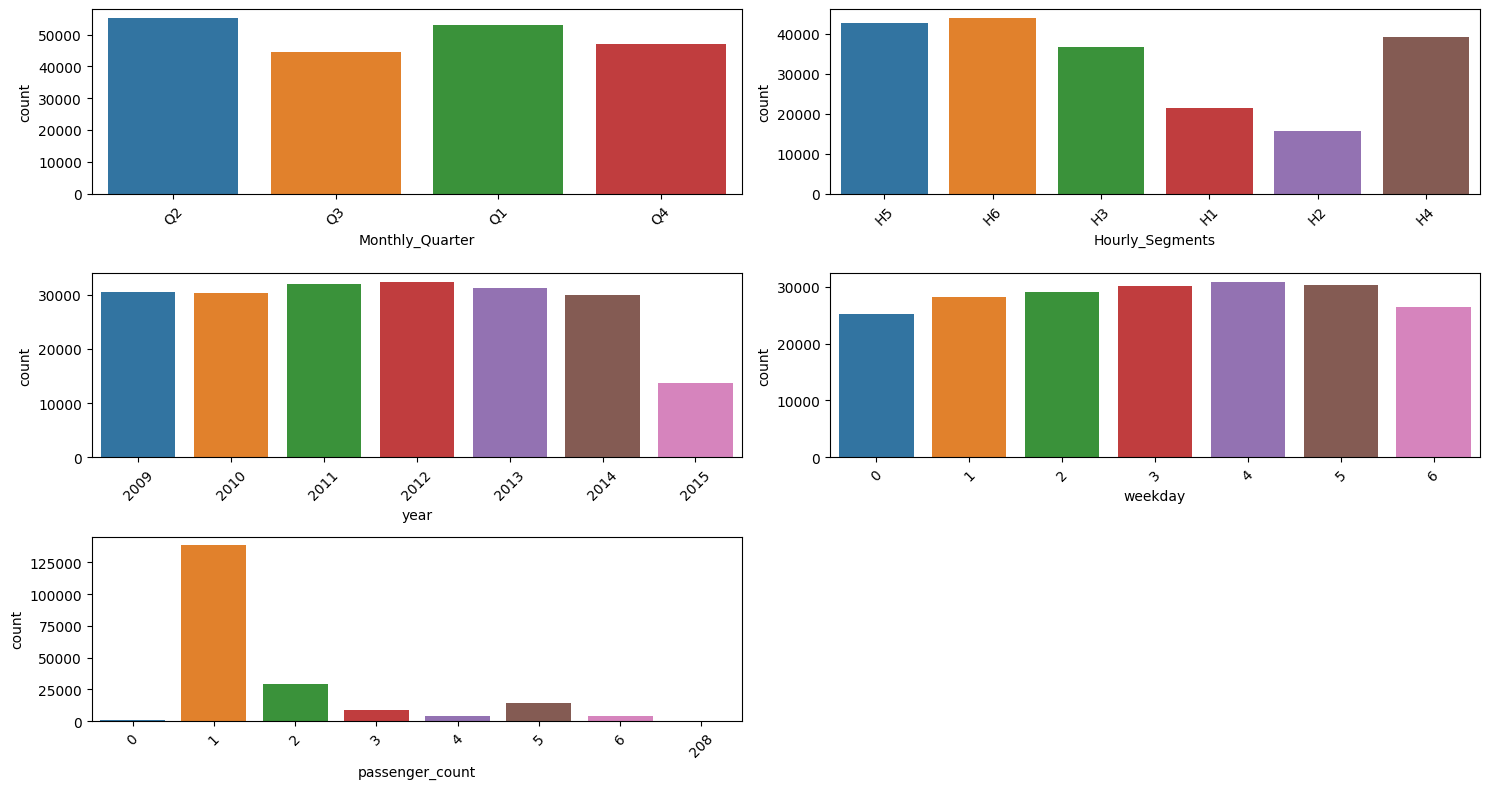

In [61]:
# Visualizing the categorical features

print('\033[1mVisualising Categorical Features:'.center(100))

n = 2  # Number of plots per row (adjust as needed)
plt.figure(figsize=(15, 8))

for i in range(len(cf)):
    # Check if the number of unique values in the column is less than or equal to 12
    if df[cf[i]].nunique() <= 12:
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        # Use x=cf[i] to specify the column as x-axis for countplot
        sns.countplot(x=cf[i], data=df)
        plt.xticks(rotation=45)  # Rotate x labels if needed
    else:
        plt.subplot(3, 1, i-3)
        sns.histplot(df[cf[i]], kde=False)
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Numerical Features Distribution


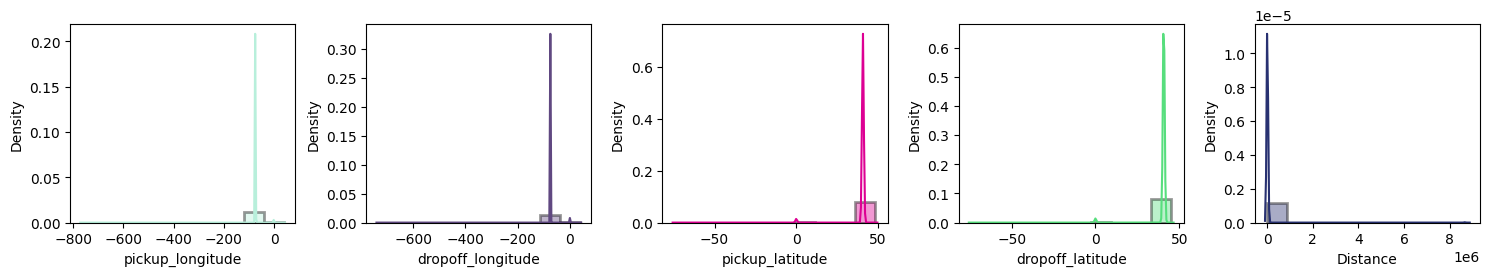

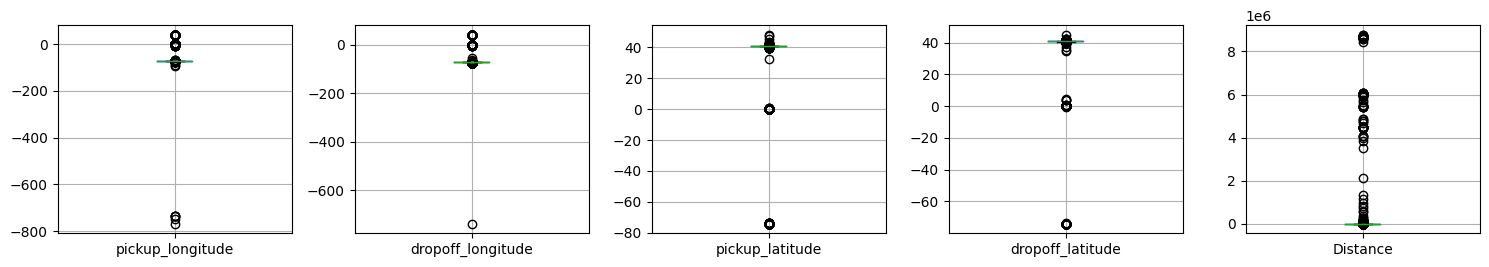

In [62]:
# Visualizing the numerical features

print('\033[1mNumerical Features Distribution')

n=5

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])

for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

In [63]:
# Explore the relationship between all the features

'''g = sns.pairplot(df)
plt.title('Pairplot for all the Features')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()'''

'g = sns.pairplot(df)\nplt.title(\'Pairplot for all the Features\')\ng.map_upper(sns.kdeplot, levels=4, color=".2")\nplt.show()'

---

# <center> 3. Data Preprocessing

In [64]:
# Remove any duplicate rows
counter = 0
rs, cs = original_df.shape

df.drop_duplicates(inplace=True)
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)

if df.shape == (rs,cs):
    print('\033[1mInference:\033[0m The dateset doesn\'t have else duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 109


In [65]:
# Convert categorical columns to Numeric

df1 = df.copy()
df3 = df1.copy()

# Excluded Categorical Columns
# Columns that are excluded from encoding based on a condition in nvc
ecc = nvc[nvc['Percentage']!=0].index.values
# Final Categorical Columns for Encoding
# Columns that are included in the encoding process, meeting certain criteria
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        # applied to binary features (columns with exactly 2 unique values). It converts the feature into a single binary column.
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), 
                         #applied to categorical features with more than 2 but fewer than 17 unique values. It creates multiple binary columns (dummy variables) for each category in the feature, except for the first category (to avoid multicollinearity).
                         pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
print(df3.shape)
display(df3)


Dummy Encoding on features:
Monthly_Quarter
Hourly_Segments
year
weekday
passenger_count
(199885, 33)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,False,True,False,False,...,True,False,False,True,False,False,False,False,False,False
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,16.0,-73.925023,40.744085,-73.973082,40.761247,4483.73,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,112.13,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1879.64,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,12867.92,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,3536.55,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [66]:
# Remove outlier

df1 = df3.copy()
df1

features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    # Interquantile range
    IQR = Q3 - Q1
    # Any values outside the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] are considered outliers and are removed from df1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,False,True,False,False,...,True,False,False,True,False,False,False,False,False,False
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,4.9,-73.969019,40.755910,-73.969019,40.755910,0.00,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False



Inference:
Before removal of outliers, The dataset had 199885 samples.
After removal of outliers, The dataset now has 163203 samples.


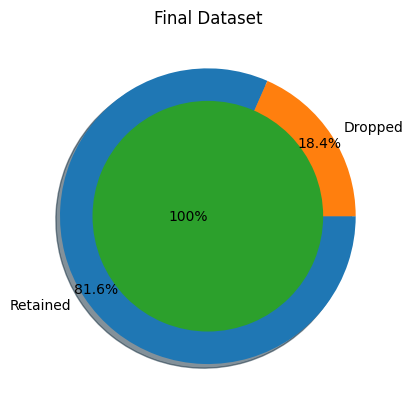

Inference: After the data preprocessing, 36791 samples were dropped,     while retaining 81.6% of the data.


In [67]:
# Final dataset size after performing data preprocessing

df = df1.copy()
df.columns = [i.replace('-', '_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius=1, 
        labels=['Retained', 'Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\033[1mInference:\033[0m After the data preprocessing, {original_df.shape[0]-df.shape[0]} samples were dropped, \
    while retaining {round(100 - ((original_df.shape[0]-df.shape[0])*100/(original_df.shape[0])),2)}% of the data.')

---

# <center> 4. Data Manipulation

In [68]:
# Splitting the data into training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))

df.columns = m
X = df.drop([target], axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y= train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True, inplace=True)

print('Original set  ---> ',X.shape,Y.shape, \
      '\nTraining set  ---> ',Train_X.shape,Train_Y.shape, \
      '\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (163203, 32) (163203,) 
Training set  --->  (130562, 32) (130562,) 
Testing set   --->  (32641, 32)  (32641,)


In [69]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,...,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05
mean,-6.304811e-13,-2.329963e-15,-1.254833e-13,1.805402e-14,-8.463960e-17,3.570074e-17,-1.414968e-17,6.312936e-18,6.639467e-17,4.767355e-17,...,2.634018e-17,-2.019051e-17,6.530624e-19,8.032667e-17,1.088437e-17,4.070755e-17,-1.904765e-18,-5.703411e-17,1.262587e-17,4.081640e-19
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.961437e+00,-2.897556e+00,-2.919757e+00,-2.867446e+00,-1.622863e+00,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
25%,-6.783829e-01,-6.847366e-01,-6.710313e-01,-6.636110e-01,-7.629052e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
50%,-6.341797e-02,3.271920e-02,-6.532058e-02,4.834418e-02,-2.347775e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
75%,6.429738e-01,6.539807e-01,6.174684e-01,6.350862e-01,5.652279e-01,1.624673e+00,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
max,3.255964e+00,2.807711e+00,3.137233e+00,2.805374e+00,2.933357e+00,1.624673e+00,1.881034e+00,1.799003e+00,3.613456e+00,2.051975e+00,...,2.329905e+00,2.371387e+00,2.630507e+00,6.643075e-01,2.425547e+00,4.605646e+00,6.741425e+00,3.651694e+00,6.828835e+00,3.613323e+02



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,...,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,3.264100e+04
mean,0.009496,0.003957,0.002645,0.010718,0.003829,-0.004419,0.008474,-0.004463,0.001664,0.002463,...,-0.001824,0.000336,-0.000882,-0.005507,0.003732,-0.006578,0.000262,0.001559,0.013835,-2.767536e-03
std,1.002215,1.000929,0.993715,1.001776,1.001768,0.997773,1.005681,0.997227,1.002787,1.001937,...,0.998279,1.000343,0.999022,1.002313,1.003758,0.985453,1.000877,1.002644,1.045127,8.673750e-19
min,-2.708732,-2.887521,-2.876670,-2.857408,-1.622863,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
25%,-0.674309,-0.688962,-0.664415,-0.652657,-0.762707,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
50%,-0.048188,0.048564,-0.060663,0.060627,-0.230528,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
75%,0.653268,0.661489,0.621690,0.657956,0.574644,1.624673,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
max,3.252830,2.800652,3.132185,2.804325,2.932838,1.624673,1.881034,1.799003,3.613456,2.051975,...,2.329905,2.371387,2.630507,0.664307,2.425547,4.605646,6.741425,3.651694,6.828835,-2.767536e-03


---

# <center> 5. Feature Selection/Extraction

                                       Correlation Matrix                                       


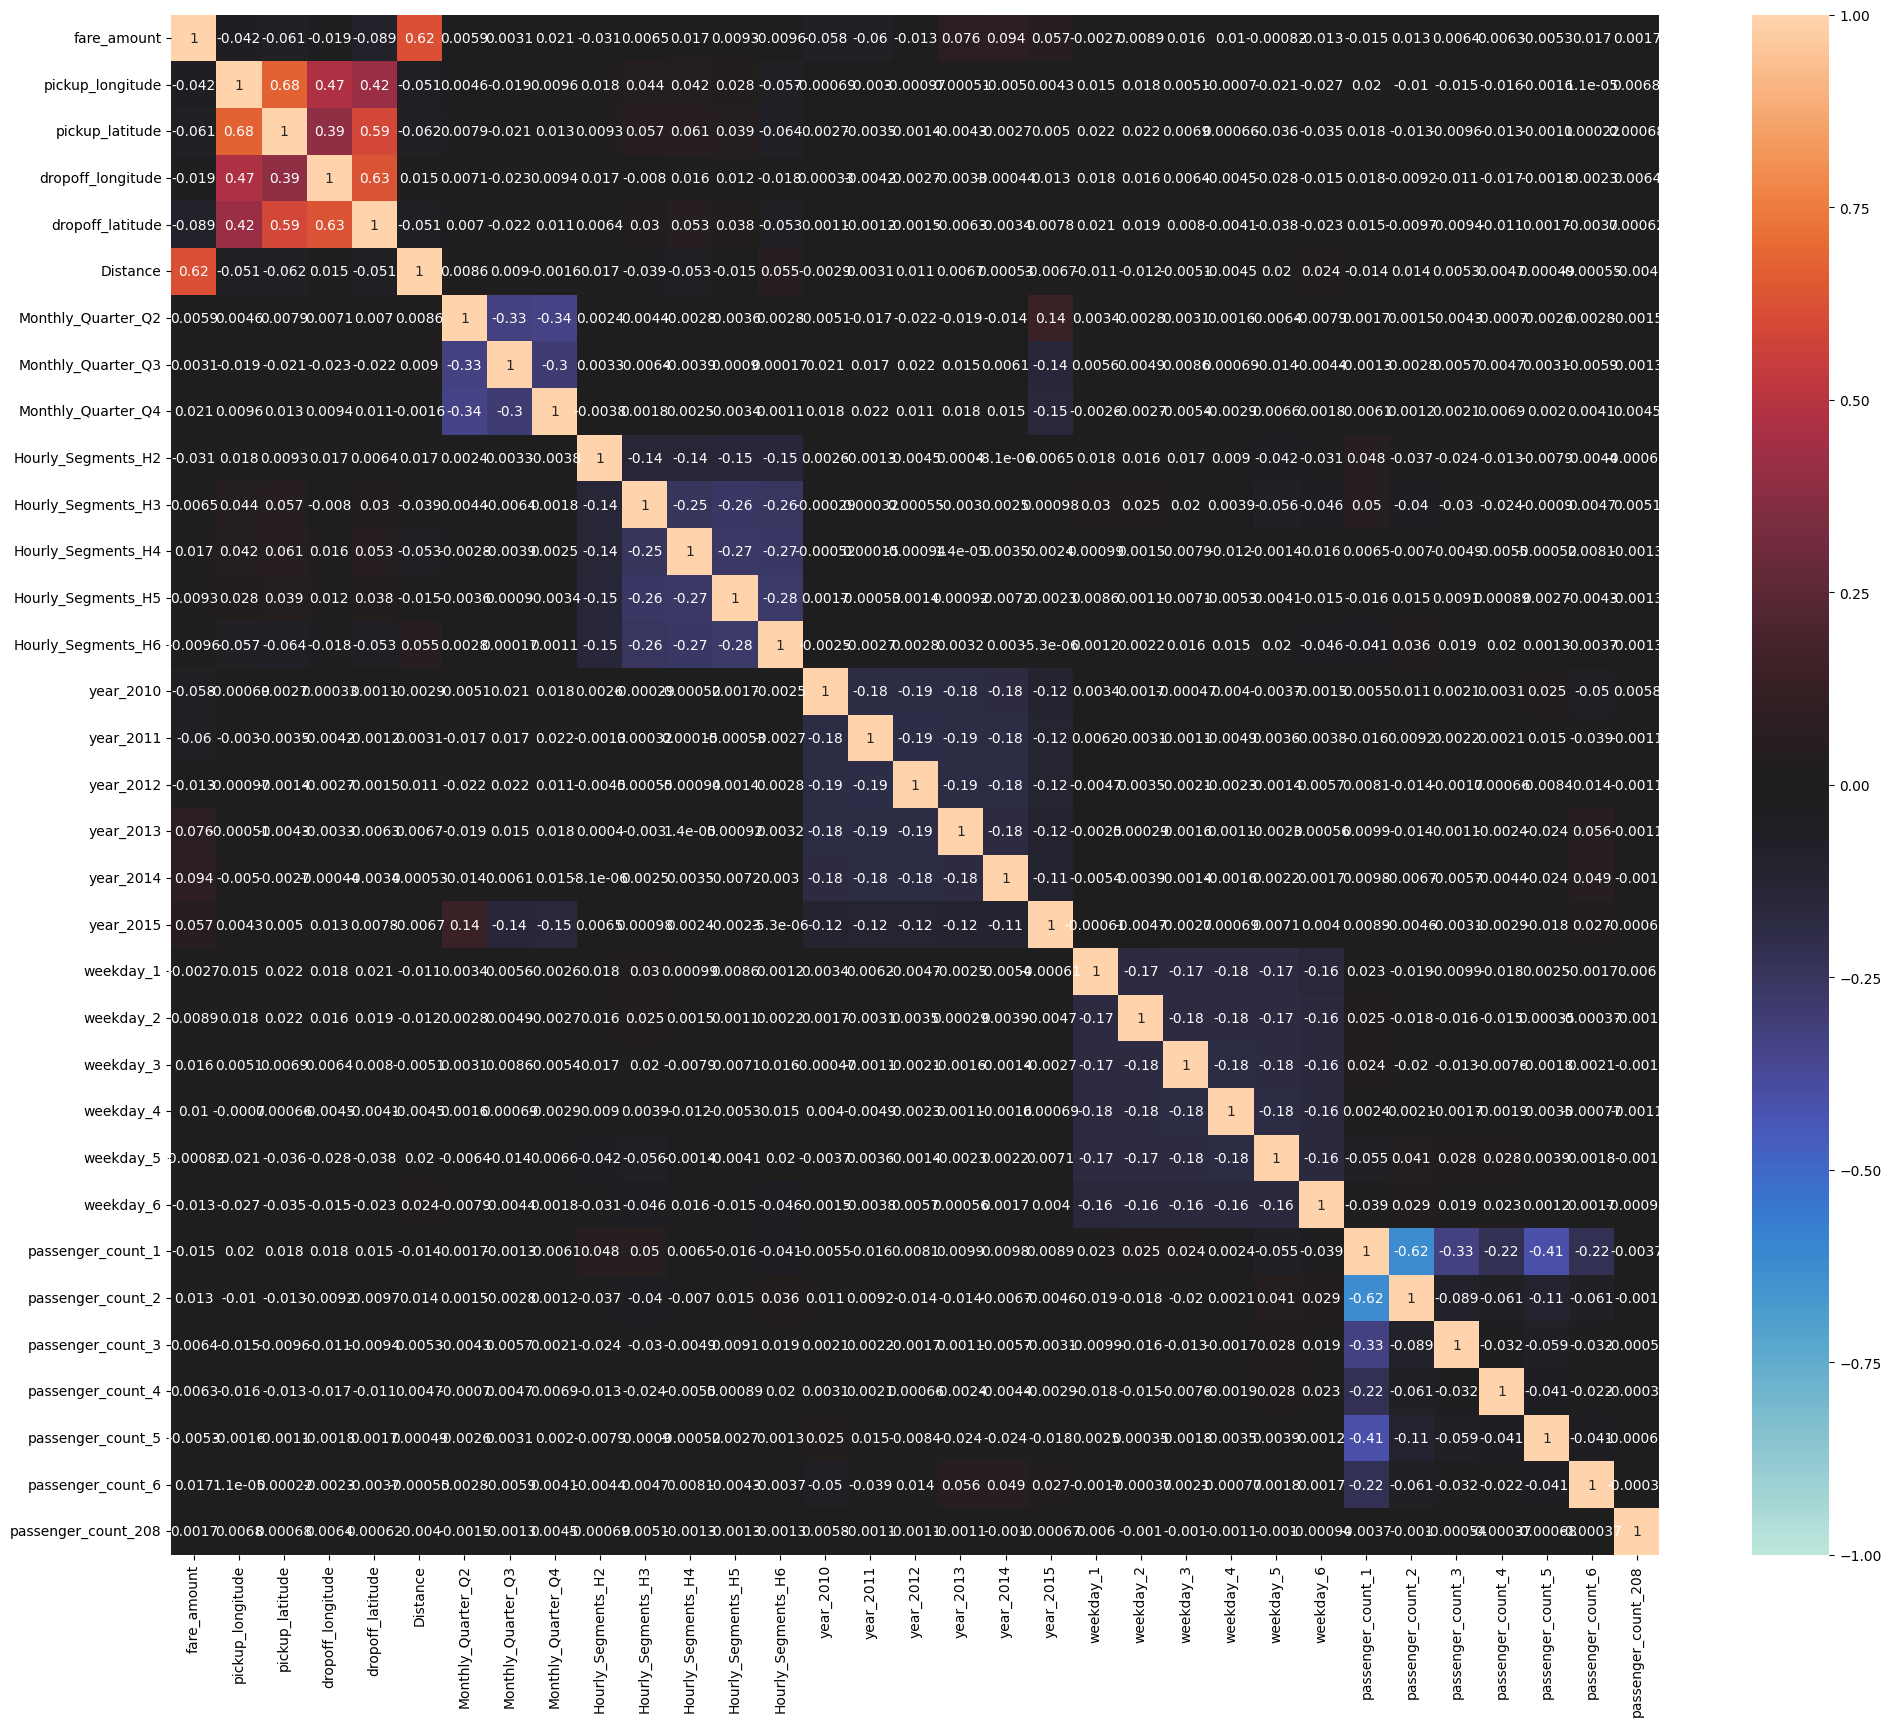

In [70]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

**Inference:** From the map,there is a strong multicorrelation between the features.
Ways to solve it:
1. Manual Method - Variance Inflation Factor (VIF)
2. Automatic Method - Recursive Feature Elimination (RFE)
3. Feature Elmination using Principal Component Analysis (PCA) Decomposition

In [71]:
# Testing a Linear Regression model with statsmodel

Train_xy = pd.concat([Train_X,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     3436.
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        07:33:40   Log-Likelihood:            -3.3661e+05
No. Observations:              130562   AIC:                         6.733e+05
Df Residuals:                  130529   BIC:                         6.736e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1036.8864     85.753     12.092      0.000     868.812    1204.961
Monthly_Quarter_Q2[T.True]      0.1479      0.024      6.174      0.000       0.101       0.195
Monthly_Quarter_Q3[T.True]      0.3185      0.026     12.348      0.000       0.268       0.369
Monthly_Quarter_Q4[T.True]      0.5197      0.025     20.525      0.000       0.470       0.569
Hourly_Segments_H2[T.True]     -0.2480      0.045     -5.563      0.000      -0.335      -0.161
Hourly_Segments_H3[T.True]      0.8033      0.036     22.239      0.000       0.733       0.874
Hourly_Segments_H4[T.True]      0.9938      0.035     28.006      0.000       0.924       1.063
Hourly_Segments_H5[T.True]      0.7011      0.035     20.017      0.000       0.632       0.770
Hourly_Segments_H6[T.True]      0.0871      0.035      2.494      0.013       0.019       0.156
year_2010[T.True]               0.1195      0.032      3.756      0.000       0.057       0.182
year_2011[T.True]               0.0771      0.032      2.445      0.015       0.015       0.139
year_2012[T.True]               0.5323      0.031     16.912      0.000       0.471       0.594
year_2013[T.True]               1.4822      0.032     46.623      0.000       1.420       1.544
year_2014[T.True]               1.7470      0.032     54.333      0.000       1.684       1.810
year_2015[T.True]               1.9042      0.041     45.907      0.000       1.823       1.985
weekday_1[T.True]               0.2489      0.034      7.300      0.000       0.182       0.316
weekday_2[T.True]               0.3675      0.034     10.824      0.000       0.301       0.434
weekday_3[T.True]               0.4200      0.034     12.465      0.000       0.354       0.486
weekday_4[T.True]               0.3504      0.034     10.453      0.000       0.285       0.416
weekday_5[T.True]               0.0497      0.034      1.464      0.143      -0.017       0.116
weekday_6[T.True]              -0.1686      0.036     -4.732      0.000      -0.238      -0.099
passenger_count_1[T.True]       0.2151      0.148      1.451      0.147      -0.075       0.506
passenger_count_2[T.True]       0.3693      0.150      2.467      0.014       0.076       0.663
passenger_count_3[T.True]       0.3946      0.154      2.569      0.010       0.094       0.696
passenger_count_4[T.True]       0.4779      0.160      2.993      0.003       0.165       0.791
passenger_count_5[T.True]       0.3229      0.152      2.130      0.033       0.026       0.620
passenger_count_6[T.True]       0.2356      0.160      1.470      0.141      -0.078       0.550
passenger_count_208[T.True]     7.7688      3.192      2.434      0.015       1.513      14.025
pickup_longitude                0.7547      0.802      0.941      0.347      -0.817       2.327
pickup_lati

From the statistic model:
- The 𝑅2 value is 0.457, meaning that about 45.7% of the variance in fare_amount is explained by the model. This suggests there is room for improvement in terms of predictive power.
- The p-values for most variables are very low (below 0.05), indicating they are statistically significant. However, some variables like weekday_5, passenger_count_1, and pickup_longitude have high p-values, implying that they may not be contributing significantly to the model.
- High standard errors for some variables (e.g., pickup_longitude and pickup_latitude) and unusual coefficients (e.g., passenger_count_208) suggest multicollinearity. The Condition Number is very high at  2.50×10^7, which confirms that multicollinearity is an issue.
- The high values for Omnibus and Jarque-Bera tests indicate that the residuals are not normally distributed, likely due to outliers or skewed data.

In [94]:
# Calculate RMSE from the model residuals
rmse = np.sqrt(np.mean(API.resid**2))
rmse


3.1874786793694505

In [98]:
# Get predictions
predictions = API.predict(Test_X)

# Calculate RMSE
rmse = np.sqrt(np.mean((Test_Y - predictions)**2))
rmse

4.133230245699863

In [99]:
# Get predictions on test set
test_predictions = API.predict(Test_X)

# Calculate RMSE
test_rmse = np.sqrt(np.mean((Test_Y - test_predictions)**2))

# Let's calculate other metrics for comparison
test_mse = np.mean((Test_Y - test_predictions)**2)
test_mae = np.mean(np.abs(Test_Y - test_predictions))
test_r2 = 1 - (np.sum((Test_Y - test_predictions)**2) / np.sum((Test_Y - Test_Y.mean())**2))

print("--------------------Testing Set Metrics for OLS Model--------------------")
print(f"R2-Score on Testing set    ---> {test_r2}")
print(f"Mean Squared Error (MSE)   ---> {test_mse}")
print(f"Root Mean Squared Error    ---> {test_rmse}")
print(f"Mean Absolute Error (MAE)  ---> {test_mae}")

--------------------Testing Set Metrics for OLS Model--------------------
R2-Score on Testing set    ---> 0.32943979743484775
Mean Squared Error (MSE)   ---> 17.08359226396815
Root Mean Squared Error    ---> 4.133230245699863
Mean Absolute Error (MAE)  ---> 1.664462545314473


In [100]:
# Get predictions on test set
test_predictions = API.predict(Test_X)

# Calculate residuals for test set
test_residuals = Test_Y - test_predictions

# Calculate RMSE for test set
test_rmse = np.sqrt(np.mean(test_residuals**2))

print("--------------------Testing Set Metrics for OLS Model--------------------")
print(f"Root Mean Squared Error (RMSE) on Test set ---> {test_rmse}")

# For comparison, let's show training RMSE too
train_rmse = np.sqrt(np.mean(API.resid**2))
print(f"Root Mean Squared Error (RMSE) on Train set ---> {train_rmse}")

--------------------Testing Set Metrics for OLS Model--------------------
Root Mean Squared Error (RMSE) on Test set ---> 4.133230245699863
Root Mean Squared Error (RMSE) on Train set ---> 3.1874786793694505


## 5a. Manual Method - VIF

100%|██████████| 31/31 [04:00<00:00,  7.75s/it]


Dropped Features -->  ['passenger_count_1', 'Hourly_Segments_H5', 'pickup_latitude', 'weekday_4', 'dropoff_longitude', 'year_2012', 'Monthly_Quarter_Q4', 'Hourly_Segments_H6', 'weekday_5', 'year_2011', 'pickup_longitude', 'weekday_1', 'Monthly_Quarter_Q2', 'year_2013', 'Hourly_Segments_H3']


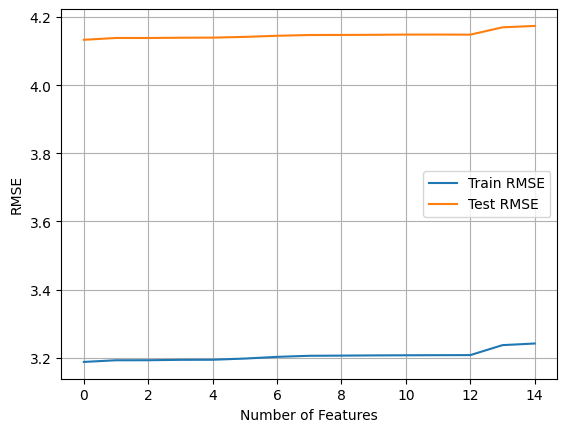

In [72]:
from sklearn.preprocessing import PolynomialFeatures
# Trr = List of RMSE values for the training set after each feature is dropped
# Tss = List of RMSE values for the test set after each feature is dropped
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]

# DROP is used to track and remove multicollinear features with high VIF
# b is unused and could be removed unless it’s meant for another purpose not shown in this code
DROP=[];b=[]

# Train_X_std = Trainig set of X after standardization
for i in tqdm(range(len(Train_X_std.columns)-1)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>=1.1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

        #Trd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Train_Y, pred1)),2)
        #Tsd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),2)
        
print('Dropped Features --> ',DROP)
#plt.plot(b)
#plt.show()
#print(API.summary())

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## 5b. Automatic MEthod - RFE

100%|██████████| 31/31 [01:12<00:00,  2.34s/it]


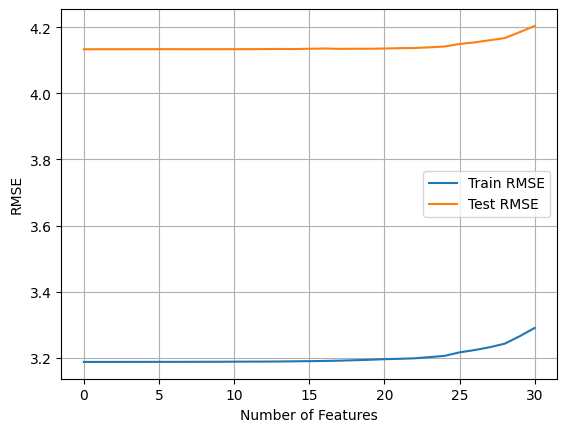

In [73]:
from sklearn.preprocessing import PolynomialFeatures
Trr = []; Tss = []; n = 3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m = df.shape[1]-2
for i in tqdm(range(m)):
    lm = LinearRegression()

    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)

    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## 5c. Feature Elimination using PCA Decomposition

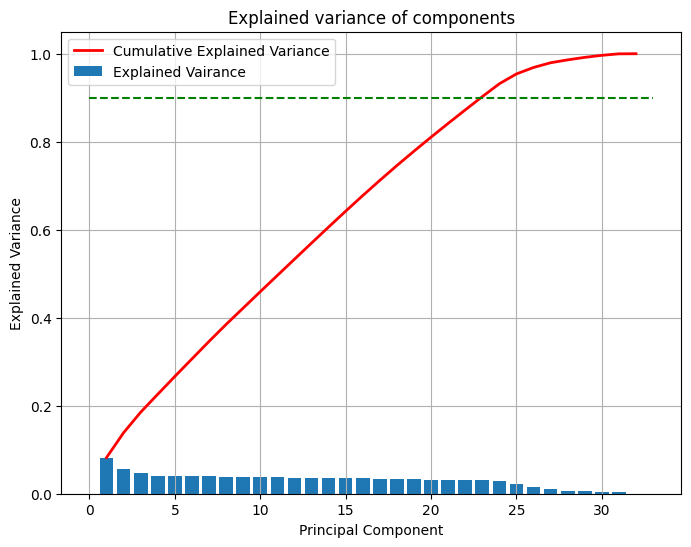

In [74]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Vairance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0, pca.n_components_+1], [0.9,0.9], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


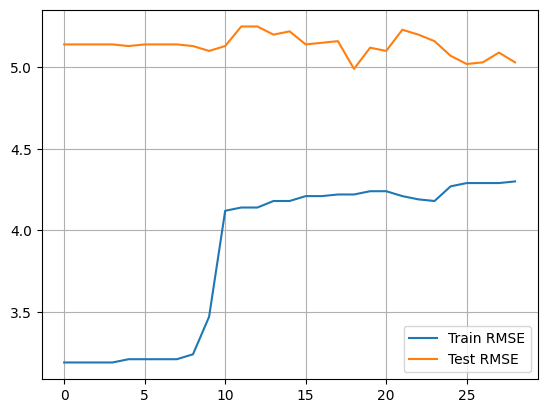

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-4

for i in tqdm(range(m)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

# plt.figure(figsize=[20,4.5])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()

#### **Inference:** 
It can be seen that the performance of the modelsis quiet comparable unpon dropping features using VIF, RFE & PCA Techniques. Comparing the RMSE plots, the optimal values were found for dropping most features using manual RFE Technique.

In [76]:
# Shortlisting the selected features (with RFE)

lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=df.shape[1]-23)
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

pred1 = LR.predict(Train_X_std.loc[:, rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:, rfe.support_])

# Root Mean Square Error (RMSE): Used to measure the difference observed values and predicted ones
print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

# Related to 6e, without it will cause out of memory to run
Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

3.198334765136796
4.1370260899811235


---

# <center> 6. Predictive Modelling

In [77]:
# Define a function to evaluate the models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), 
                                                  columns =['Train-R2', 'Test-R2', 'Train-RSS', 'Test-RSS', 
                                                            'Train_MSE', 'Test-MSE', 'Train-RMSE', 'Test-RMSE']
                                                 )

rc = np.random.choice(Train_X_std.loc[:, Train_X_std.nunique()>50].columns, 3)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

---

## 6a. Multiple Linear Regression (MLR)

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/mr.png" style="width: 600px;float: left;"/>

<<<------------------------- Evaluating Multiple Linear Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


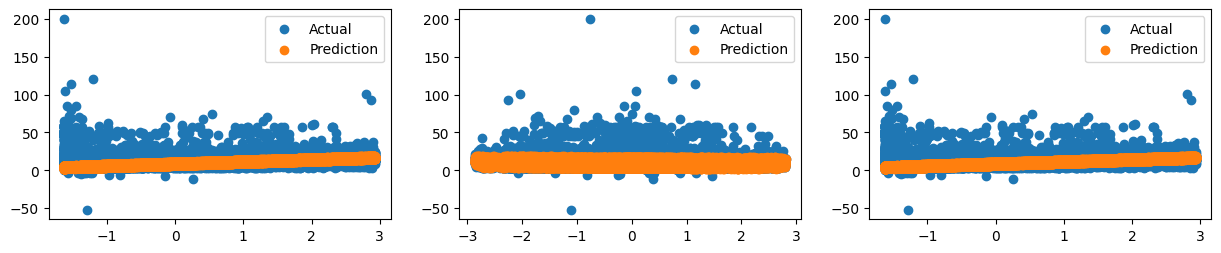



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4535189574339896
Residual Sum of Squares (RSS) on Training set  ---> 1335563.7771264177
Mean Squared Error (MSE) on Training set       ---> 10.229345269882645
Root Mean Squared Error (RMSE) on Training set ---> 3.198334765136796

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.32820758401113337
Residual Sum of Squares (RSS) on Training set  ---> 558650.2211150513
Mean Squared Error (MSE) on Training set       ---> 17.1149848691845
Root Mean Squared Error (RMSE) on Training set ---> 4.1370260899811235

--------------------Residual Plots--------------------


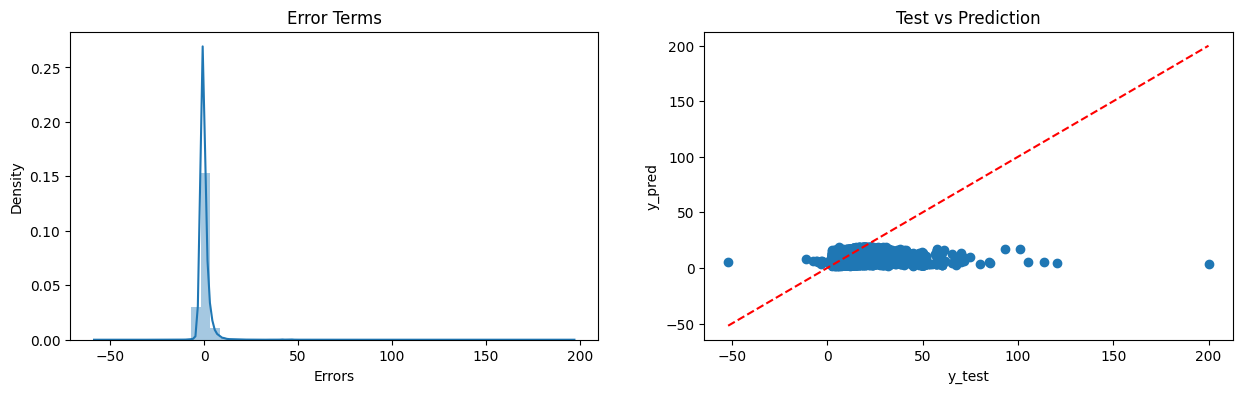

In [78]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

---

## 6b. Ridge Regression Model

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/ridge.png" style="width: 500px;float: left;"/>

<<<------------------------- Evaluating Ridge Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


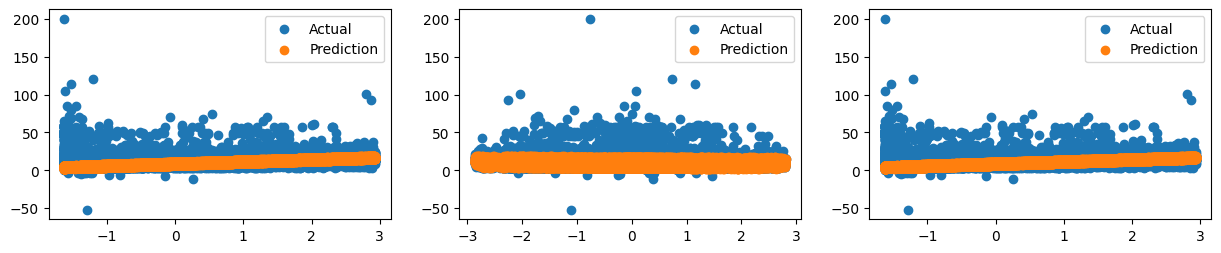



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.453518957400977
Residual Sum of Squares (RSS) on Training set  ---> 1335563.7772070984
Mean Squared Error (MSE) on Training set       ---> 10.229345270500593
Root Mean Squared Error (RMSE) on Training set ---> 3.1983347652334007

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.32820764693130466
Residual Sum of Squares (RSS) on Training set  ---> 558650.1687917938
Mean Squared Error (MSE) on Training set       ---> 17.114983266192635
Root Mean Squared Error (RMSE) on Training set ---> 4.137025896243899

--------------------Residual Plots--------------------


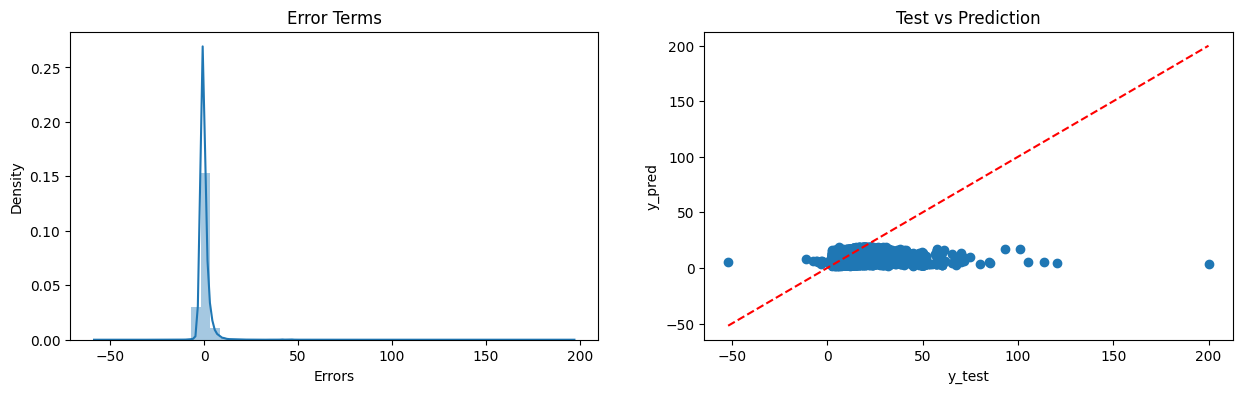

In [79]:
# Create a Ridge Regression Model

RLR = Ridge().fit(Train_X_std, Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

---

## 6c. Lasso Regression Model

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/lasso.png" style="width: 500px;float: left;"/>

<<<------------------------- Evaluating Lasso Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


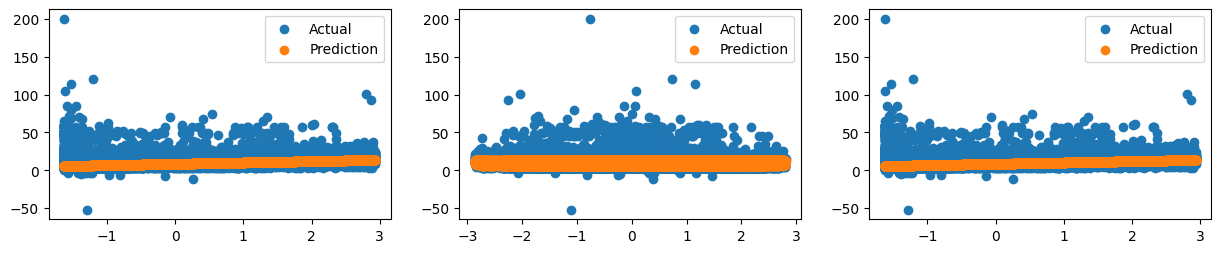



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.3585502318636643
Residual Sum of Squares (RSS) on Training set  ---> 1567661.1052167423
Mean Squared Error (MSE) on Training set       ---> 12.007024288971845
Root Mean Squared Error (RMSE) on Training set ---> 3.4651153355944513

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.2622605216343987
Residual Sum of Squares (RSS) on Training set  ---> 613490.5856410799
Mean Squared Error (MSE) on Training set       ---> 18.795091622226032
Root Mean Squared Error (RMSE) on Training set ---> 4.335330624326827

--------------------Residual Plots--------------------


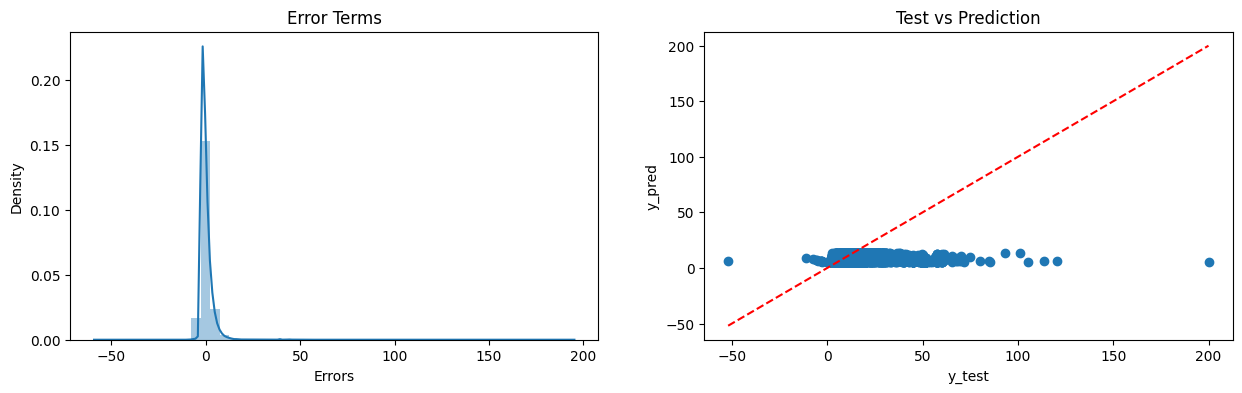

In [80]:
# Create a Lasso Regression Model

LLR = Lasso().fit(Train_X_std, Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

---

## 6d. Elastic-Net Regression

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/en.png" style="width: 500px;float: left;"/>

<<<------------------------- Evaluating Elastic-Net Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


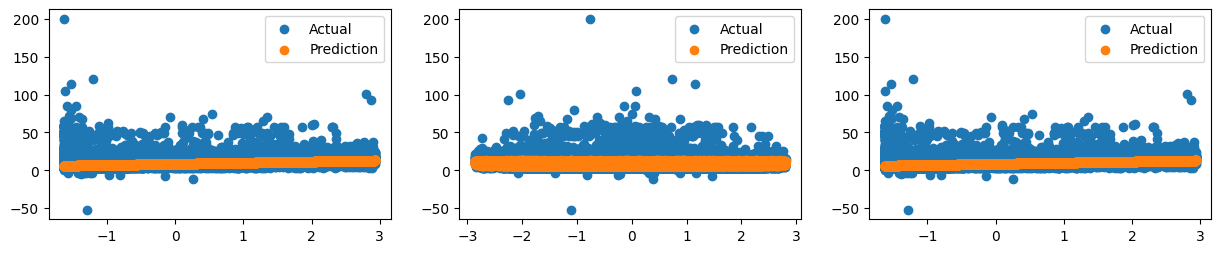



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.32729497804639207
Residual Sum of Squares (RSS) on Training set  ---> 1644046.8928137545
Mean Squared Error (MSE) on Training set       ---> 12.5920780381256
Root Mean Squared Error (RMSE) on Training set ---> 3.5485318144446163

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.23952090035803764
Residual Sum of Squares (RSS) on Training set  ---> 632400.4365887307
Mean Squared Error (MSE) on Training set       ---> 19.374419796842336
Root Mean Squared Error (RMSE) on Training set ---> 4.401638308271402

--------------------Residual Plots--------------------


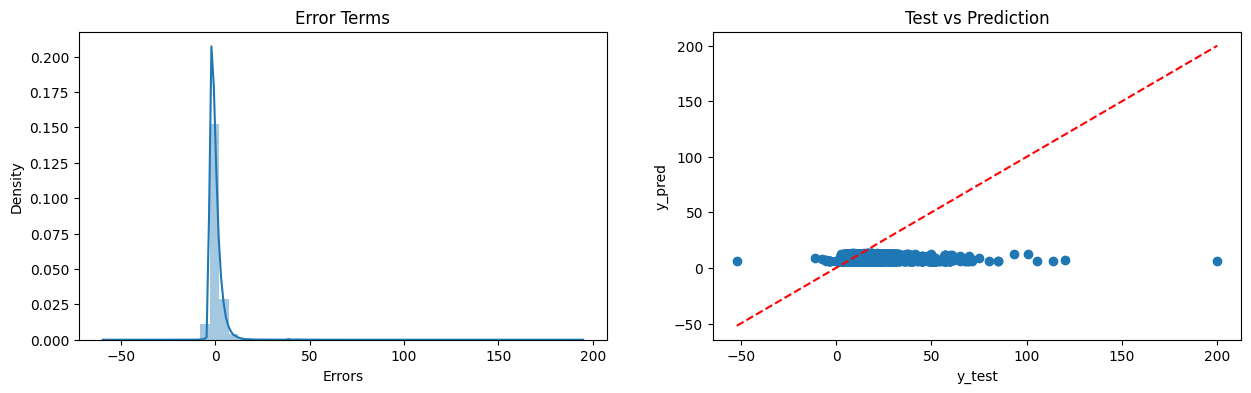

In [81]:
# Create Elastic-Net Regression model

ENR = ElasticNet().fit(Train_X_std, Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

---

## 6e. Polynomial Regression Model

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/pn.png" style="width: 500px;float: left;"/>

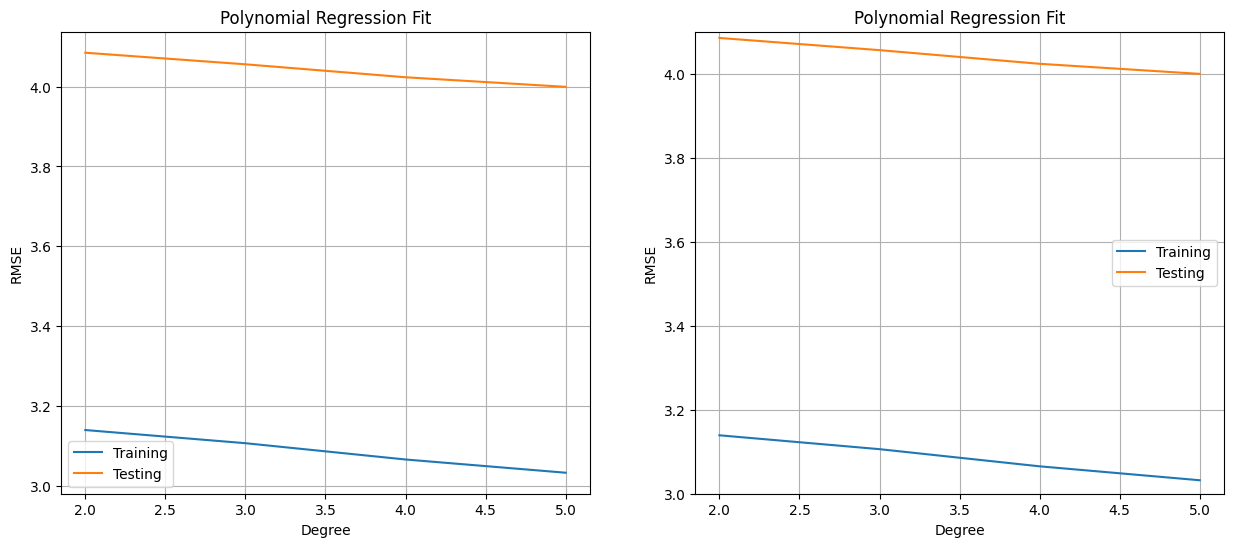

In [82]:
#Checking polynomial regression performance on various degrees

# Trr is a list that stores the Root Mean Squared Error (RMSE) values of the training set for each polynomial degree
# Tss is a list that stores the RMSE values of the testing set for each polynomial degree
Trr=[]; Tss=[]
n_degree=6

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([3,4.1])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

**Inference:** We can choose 5th order polynomial regression as it gives the optimal training & testing scores...

<<<------------------------- Evaluating Polynomial Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


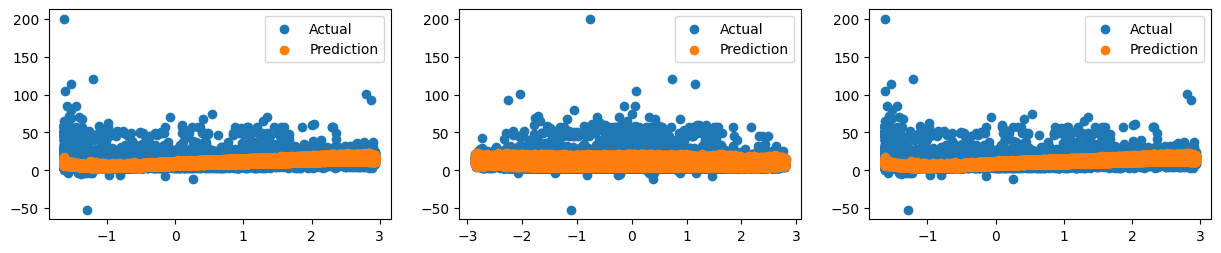



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.5088602120556582
Residual Sum of Squares (RSS) on Training set  ---> 1200313.3854451682
Mean Squared Error (MSE) on Training set       ---> 9.193435957209358
Root Mean Squared Error (RMSE) on Training set ---> 3.032067934134946

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.37208430334974973
Residual Sum of Squares (RSS) on Training set  ---> 522163.1480595447
Mean Squared Error (MSE) on Training set       ---> 15.997155358584134
Root Mean Squared Error (RMSE) on Training set ---> 3.999644404016954

--------------------Residual Plots--------------------


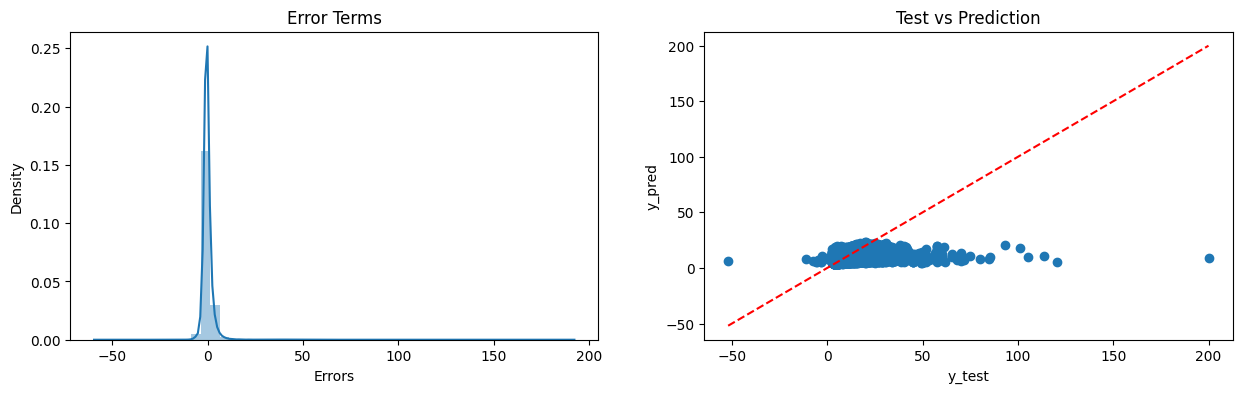

In [83]:
#Using the 5th Order Polynomial Regression model (degree=5)

poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

---

### 6f. Comparing the Evaluation Metics of the Models

In [84]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train_MSE,Test-MSE,Train-RMSE,Test-RMSE,Train-MSE
Multiple Linear Regression (MLR),0.453519,0.328208,1.335564e+06,558650.221115,0.0,17.114985,3.198335,4.137026,10.229345
Ridge Linear Regression (RLR),0.358550,0.262261,1.567661e+06,613490.585641,0.0,18.795092,3.465115,4.335331,12.007024
Lasso Linear Regression (LLR),0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,NaN
Elastic-Net Regression (ENR),0.327295,0.239521,1.644047e+06,632400.436589,0.0,19.374420,3.548532,4.401638,12.592078
Polynomial Regression (PNR),0.508860,0.372084,1.200313e+06,522163.148060,0.0,15.997155,3.032068,3.999644,9.193436


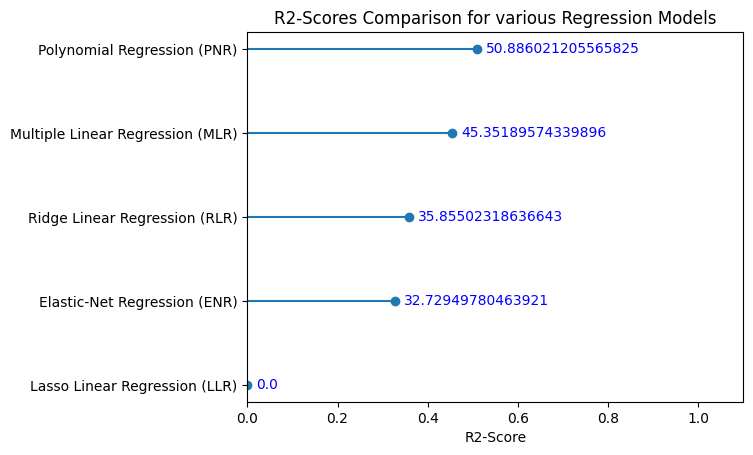

In [85]:
# R2-Scores Comparison for different Regression Models

R2 = EMC['Train-R2'].sort_values(ascending=True)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

**Inference:** From the graph, it shows that polynomial regression model has the highest explainability power to understnad the dataset

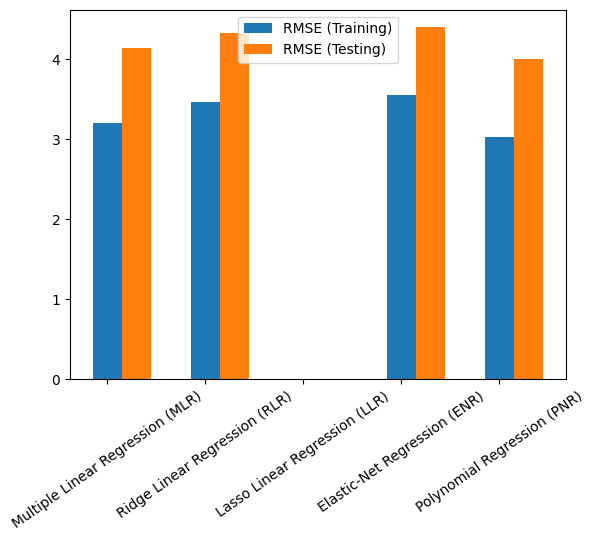

In [86]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
# baxes = brokenaxes(ylims=((0,4),(524,532)))
# baxes.bar(np.arange(s), Model_Evaluation_Comparison_Matrix[cc[-2]].values, width=0.3, label='RMSE (Training)')
# baxes.bar(np.arange(s)+0.3, Model_Evaluation_Comparison_Matrix[cc[-1]].values, width=0.3, label='RMSE (Testing)')
# for index, value in enumerate(Model_Evaluation_Comparison_Matrix[cc[-2]].values):
#     plt.text(round(value,2), index, str(round(value,2)))
# for index, value in enumerate(Model_Evaluation_Comparison_Matrix[cc[-1]].values):
#     plt.text(round(value,2), index, str(round(value,2)))
plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation=35)
plt.legend()
#plt.ylim([0,10])
plt.show()

**Inference:** The complex models like polynomial (degree-5) performs the best on the current dataset. For this problem, it is can be said that even simple regression can be a good choice to go with..

---

# <center> 7. Project Outcomes & Conclusions

## Key outcomes of the project:
- The large dataset, which contains 2M samples, are remaining with a 81.6% of data samples after preprocessing
- Since features has high multicollinearity, we filter out the appropriate features with the most appropriate technique, Recursive Features Elimination (RFE) during feature extraction
- Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset
- While, Polynomial Regression (Order-5) was the best choise, yet it is safe to use multiple regression algorithm, as their scores were quiet comparable & also they're more generalisable.

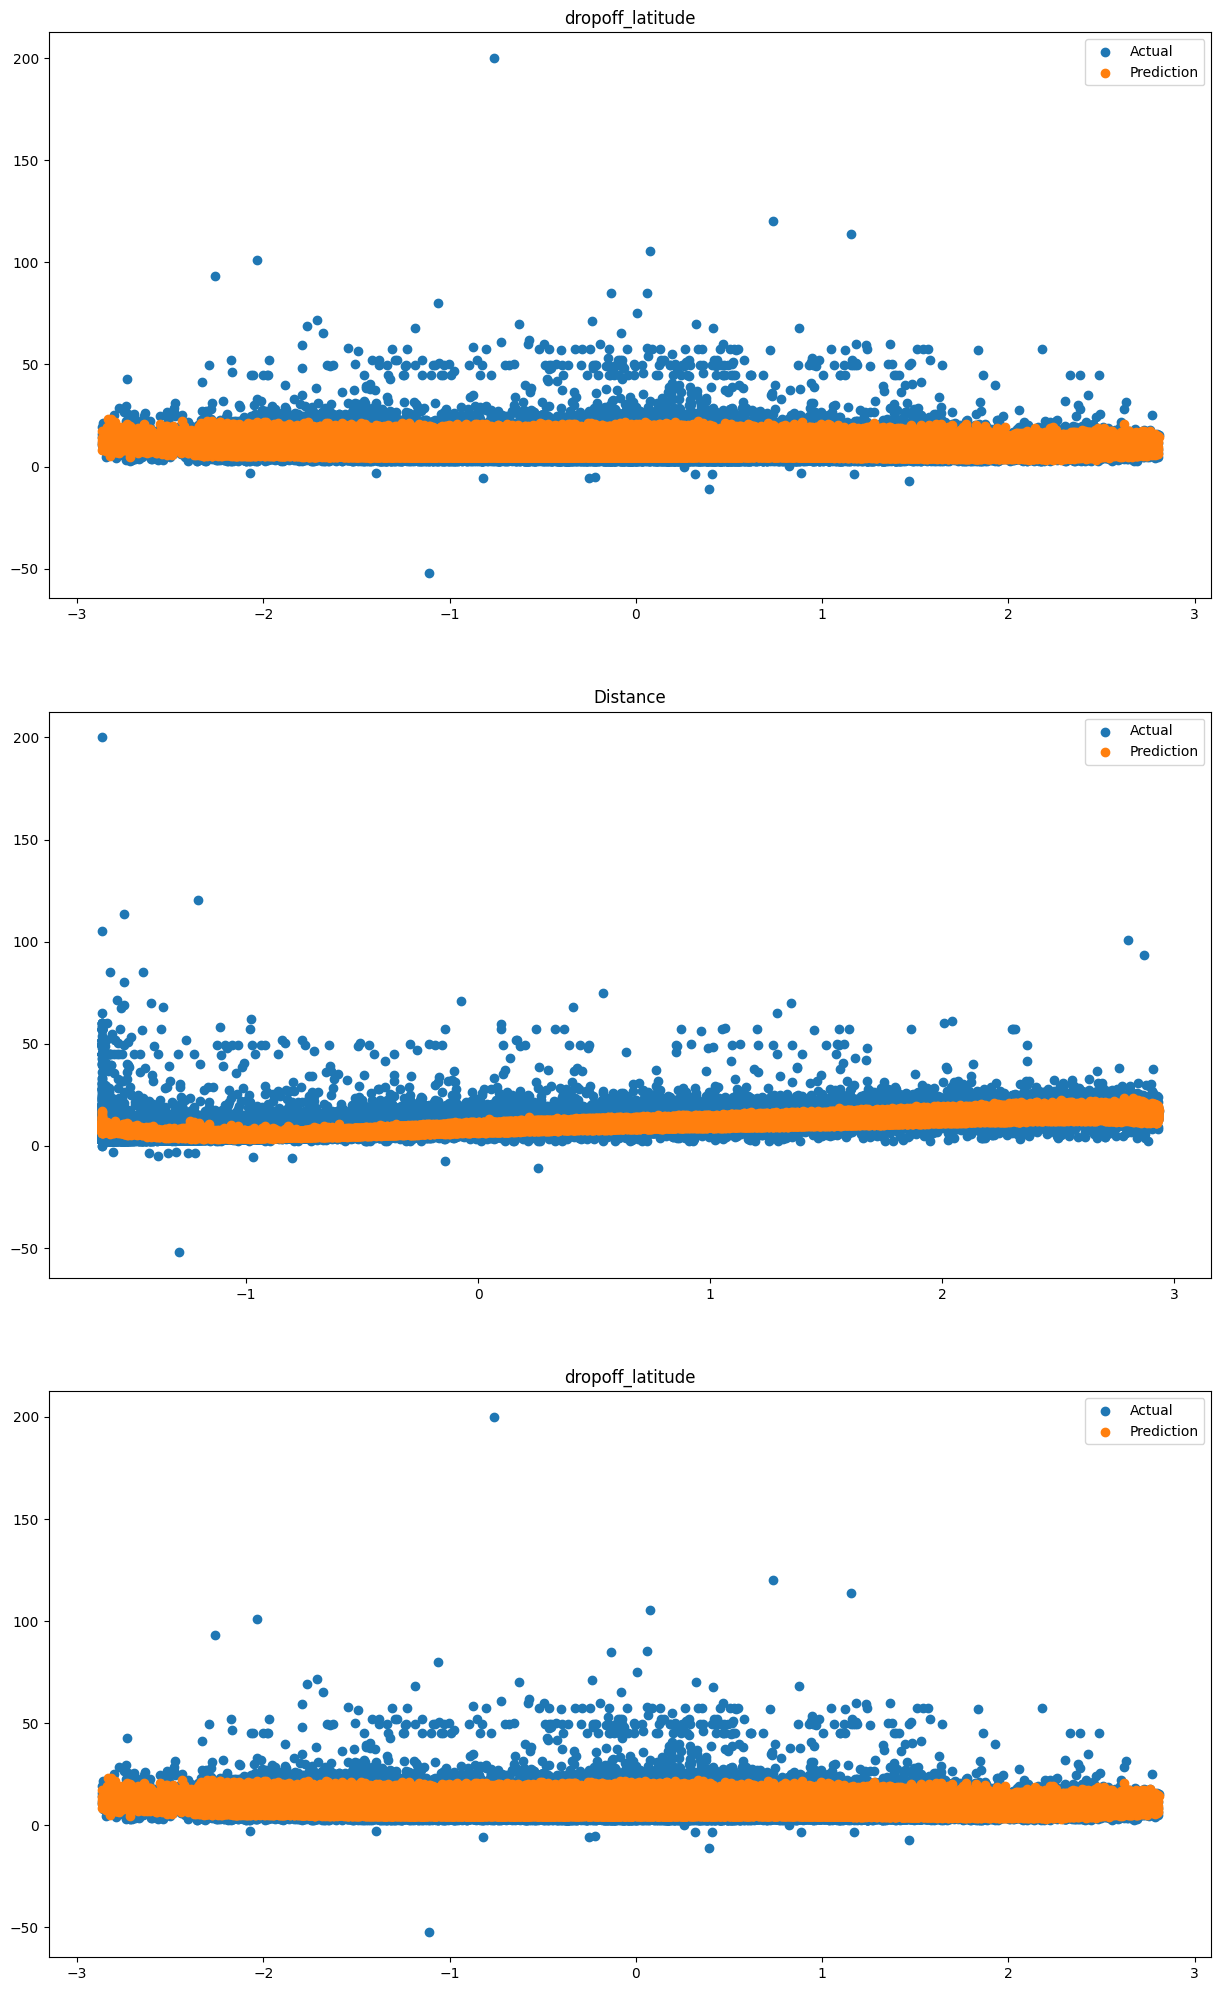

In [87]:
poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)


rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>50].columns,3)

plt.figure(figsize=[15,25])
for e,i in enumerate(rc):
    plt.subplot(3,1,e+1)
    plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
    plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
    plt.title(i)
    plt.legend()
plt.show()

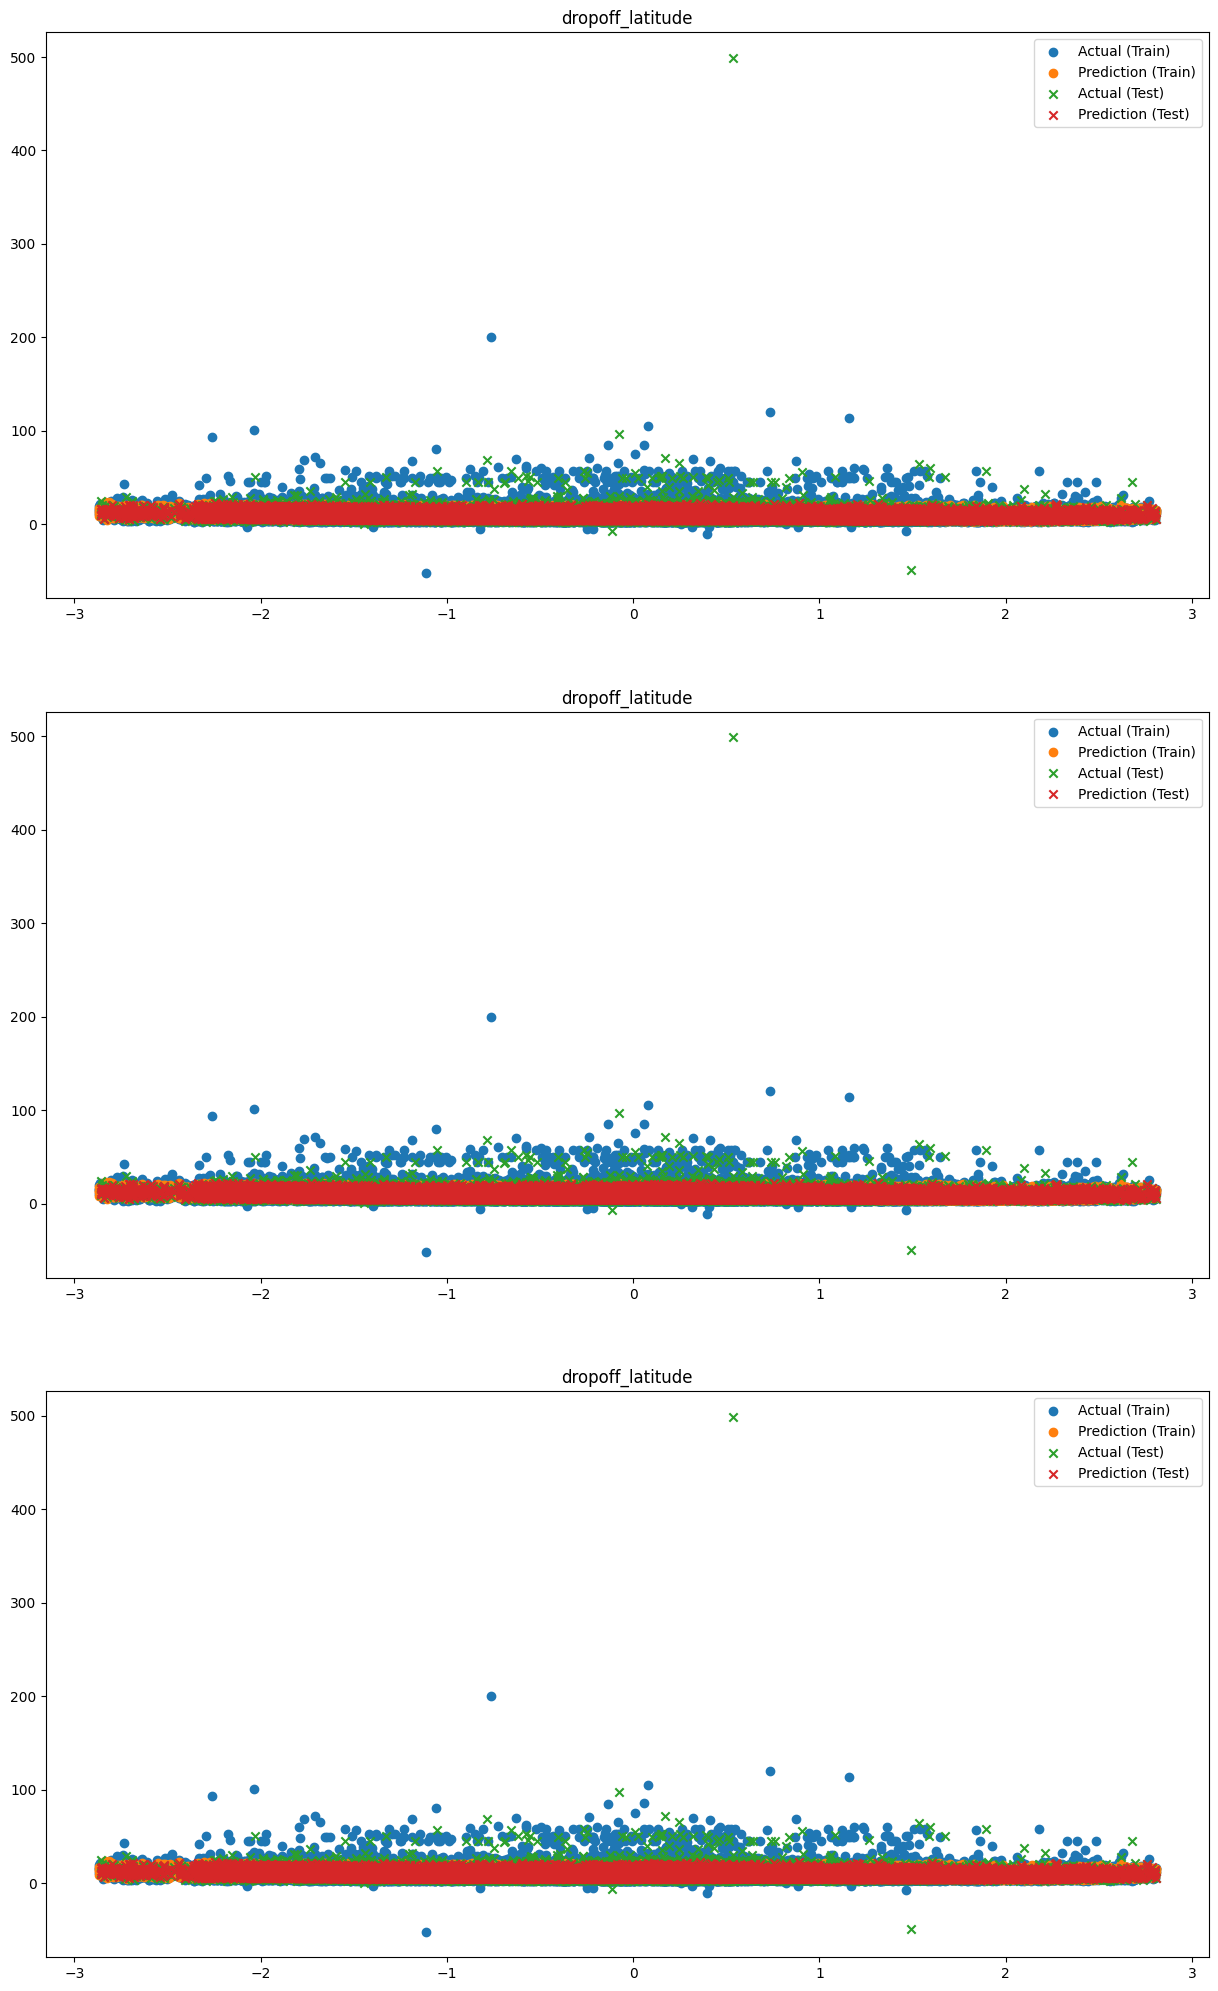

In [88]:
poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)


rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>50].columns,3)

plt.figure(figsize=[15,25])
for e,i in enumerate(rc):
    plt.subplot(3,1,e+1)
    # Training data
    plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual (Train)')
    plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction (Train)')
    
    # Test data
    plt.scatter(y=Test_Y, x=Test_X_std[i], label='Actual (Test)', marker='x')
    plt.scatter(y=pred2, x=Test_X_std[i], label='Prediction (Test)', marker='x')
    plt.title(i)
    plt.legend()
plt.show()

In [89]:
#combine_data = pd.concat(pred1)
pd.DataFrame(pred1)

,0
0,6.726124
1,11.111244
2,7.494171
3,6.553493
4,12.319733
...,...
130557,5.879044
130558,5.199303
130559,8.157600
130560,10.224323


---

# Model Evaluation

In [90]:
# Assume `predicted_fares` is the array of predicted fare amounts
# and `actual_fares` is the array of actual fare amounts.

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Test_Y, pred2)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Test_Y, pred2)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Optionally, you can calculate R-squared for an overall fit assessment
from sklearn.metrics import r2_score
r2 = r2_score(Test_Y, pred2)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 1.6093157980207653
Mean Squared Error (MSE): 15.997155358584134
Root Mean Squared Error (RMSE): 3.999644404016954
R-squared (R2): 0.37208430334974973


In [101]:
# Calculate percentage improvement on testing dataset
ols_rmse = 4.133230245699863
poly_rmse = 3.999644404016954

improvement = ols_rmse - poly_rmse
percentage_improvement = (improvement / ols_rmse) * 100

print(f"Absolute improvement in RMSE: ${improvement:.3f}")
print(f"Percentage improvement: {percentage_improvement:.2f}%")

Absolute improvement in RMSE: $0.134
Percentage improvement: 3.23%
